# EV Charging Load Modeling

This notebook explores EV Charging Load Modeling and Prediction. It It develops the following models: 

- Bayesian linear model using PyMC
- Random Forest model using scikit-learn
- TODO: Gaussian Process Regression

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import numpy as np

In [2]:
sns.set_theme()

In [3]:
raw_data = pd.read_csv("../data/Electric_Vehicle_Charging_Station_Data.csv")

In [4]:
raw_data

,ObjectId2,Station_Name,Address,City,State_Province,Zip_Postal_Code,Start_Date___Time,Start_Time_Zone,End_Date___Time,End_Time_Zone,Total_Duration__hh_mm_ss_,Charging_Time__hh_mm_ss_,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,Port_Type,ObjectID
0,1,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/1/2018 17:49,MDT,1/1/2018 19:52,MDT,2:03:02,2:02:44,6.504,2.732,0.816,Level 2,0
1,2,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/2/2018 8:52,MDT,1/2/2018 9:16,MDT,0:24:34,0:24:19,2.481,1.042,0.311,Level 2,1
2,3,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/2/2018 21:11,MDT,1/3/2018 6:23,MDT,9:12:21,3:40:52,15.046,6.319,1.888,Level 2,2
3,4,BOULDER / ALPINE ST1,1275 Alpine Ave,Boulder,Colorado,80304,1/3/2018 9:19,MDT,1/3/2018 11:14,MDT,1:54:51,1:54:29,6.947,2.918,0.872,Level 2,3
4,5,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,1/3/2018 14:13,MDT,1/3/2018 14:30,MDT,0:16:58,0:16:44,1.800,0.756,0.226,Level 2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70189,70190,MUNICIPAL SC / 1100WALNUT1,1100 Walnut,Boulder,Colorado,80302,2023-08-31 09:20:52,MDT,2023-08-31 10:56:11,MDT,01:35:13,00:49:39,2.360,1.675,0.296,Level 2,70125
70190,70191,MUNICIPAL SC / 1104 SPRUCE1,1100 Spruce St,Boulder,Colorado,80302,2023-08-31 09:24:16,MDT,2023-08-31 10:26:58,MDT,01:02:42,01:02:28,6.277,4.457,0.788,Level 2,70126
70191,70192,BOULDER / ATRIUM ST1,1770 13th St,Boulder,Colorado,80302,2023-08-31 09:39:36,MDT,2023-08-31 11:48:55,MDT,02:09:22,02:09:08,12.933,9.183,1.623,Level 2,70127
70192,70193,BOULDER / REC CENTER ST2,1360 Gillaspie Dr,Boulder,Colorado,80305,2023-08-31 09:41:08,MDT,2023-08-31 10:55:27,MDT,01:14:21,01:14:09,7.512,5.334,0.943,Level 2,70128


In [5]:
raw_data.describe()

,ObjectId2,Zip_Postal_Code,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,ObjectID
count,70194.000000,70194.000000,70194.000000,70194.000000,70194.000000,70194.000000
mean,35097.500000,80302.573724,8.450916,5.258133,1.060591,35096.500000
std,20263.406735,1.108910,8.807785,5.919214,1.105376,20263.406735
min,1.000000,80301.000000,0.000000,0.000000,0.000000,0.000000
25%,17549.250000,80302.000000,2.842250,1.597000,0.357000,17548.250000
50%,35097.500000,80302.000000,6.240000,3.676500,0.783000,35096.500000
75%,52645.750000,80303.000000,11.373000,6.851000,1.427000,52644.750000
max,70194.000000,80305.000000,92.691000,65.811000,11.633000,70193.000000


In [6]:
raw_data.columns

Index(['ObjectId2', 'Station_Name', 'Address', 'City', 'State_Province',
       'Zip_Postal_Code', 'Start_Date___Time', 'Start_Time_Zone',
       'End_Date___Time', 'End_Time_Zone', 'Total_Duration__hh_mm_ss_',
       'Charging_Time__hh_mm_ss_', 'Energy__kWh_', 'GHG_Savings__kg_',
       'Gasoline_Savings__gallons_', 'Port_Type', 'ObjectID'],
      dtype='object')

In [7]:
raw_data["start_time"] = pd.to_datetime(raw_data['Start_Date___Time'].values, format='mixed')
raw_data["end_time"] = pd.to_datetime(raw_data['End_Date___Time'].values, format='mixed')

In [8]:
pd.to_datetime("2019-01-01")

Timestamp('2019-01-01 00:00:00')

Text(0.5, 1.0, 'Charging events')

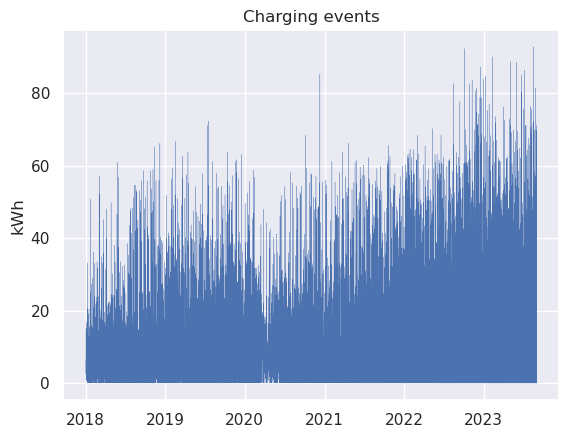

In [9]:
fig, ax = plt.subplots()

d = raw_data
d = d.sort_values("start_time")

ax.plot(d.start_time, d["Energy__kWh_"], linewidth=.2)
ax.set_ylabel("kWh")
ax.set_title("Charging events")

In [10]:
data = pd.DataFrame()
data["hour"] = raw_data["start_time"].dt.hour
data["day"] = raw_data["start_time"].dt.dayofweek
data["year"] = raw_data["start_time"].dt.year
year_idx, years = pd.factorize(data["year"])
data["year_idx"] = year_idx
data["kWh"] = raw_data["Energy__kWh_"]
data

,hour,day,year,year_idx,kWh
0,17,0,2018,0,6.504
1,8,1,2018,0,2.481
2,21,1,2018,0,15.046
3,9,2,2018,0,6.947
4,14,2,2018,0,1.800
...,...,...,...,...,...
70189,9,3,2023,5,2.360
70190,9,3,2023,5,6.277
70191,9,3,2023,5,12.933
70192,9,3,2023,5,7.512


In [11]:
# total kWh by hour and day
X = data.groupby(['year_idx', 'day', 'hour'])['kWh'].sum().reset_index()
X["kWh_std"] = (X["kWh"] - X["kWh"].mean()) / X["kWh"].std()

X

,year_idx,day,hour,kWh,kWh_std
0,0,0,1,1.610,-1.020487
1,0,0,5,84.409,-0.889115
2,0,0,6,140.527,-0.800076
3,0,0,7,450.078,-0.308932
4,0,0,8,887.326,0.384822
...,...,...,...,...,...
915,5,6,19,888.982,0.387450
916,5,6,20,591.743,-0.084161
917,5,6,21,351.111,-0.465956
918,5,6,22,138.291,-0.803624


In [12]:
len(years)

6

In [13]:
coords = {
    "year": np.arange(len(years)),
    "hour": np.arange(24),
    "day": np.arange(7),
}

## Model: Hour, day, year

Given:
- $ \alpha $: Intercept
- $ \beta_i $: Effect of the i-th hour of the day (for $ i = 1, 2, ..., 24 $)
- $ \gamma_j $: Effect of the j-th day of the week (for $ j = 1, 2, ..., 7 $)
- $ \delta_k $: Effect of the k-th year (for $ k = 0, 1, ..., 6 $)
- $ \mu $: Expected kWh charged for a given hour and day
- $ \sigma $: Standard deviation of the observations
- $ Y $: Observed kWh charged (standardized)

The model can be represented as:

1. Prior on the intercept:
$$ \alpha \sim \mathcal{N}(0, 1) $$

2. Priors on the hourly effects:
$$ \beta_i \sim \mathcal{N}(0, 1) \quad \text{for} \quad i = 1, 2, ..., 24 $$

3. Priors on the daily effects:
$$ \gamma_j \sim \mathcal{N}(0, 1) \quad \text{for} \quad j = 1, 2, ..., 7 $$

4. Priors on the yearly effects:

$$ \delta_k \sim \mathcal{N}(0, 1) \quad \text{for} \quad k = 1, 2, ..., 6 $$

5. Prior on the standard deviation:
$$ \sigma \sim \text{HalfNormal}(1) $$

6. The linear model for the expected kWh charged given hour and day:
$$ \mu = \alpha + \beta_{X_{\text{hour}}} + \gamma_{X_{\text{day}}} + \delta_{X_{\text{year}}} $$

7. The likelihood of the observed data:
$$ Y \sim \mathcal{N}(\mu_i, \sigma) $$


In [14]:
with pm.Model(coords=coords) as model:
    alpha = pm.Normal("alpha", 0, 1)
    # hour of day
    beta = pm.Normal("beta", 0, 1, dims="hour")
    # day of week
    gamma = pm.Normal("gamma", 0, 1, dims="day")
    # year
    delta = pm.Normal("delta", 0, 1, dims="year")
    
    mu = alpha + beta[X.hour] + gamma[X.day] + delta[X.year_idx]
    sigma = pm.HalfNormal("sigma", 1)

    obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=X.kWh_std)

In [15]:
with model:
    idata = pm.sample(tune=2000, draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, delta, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 96 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

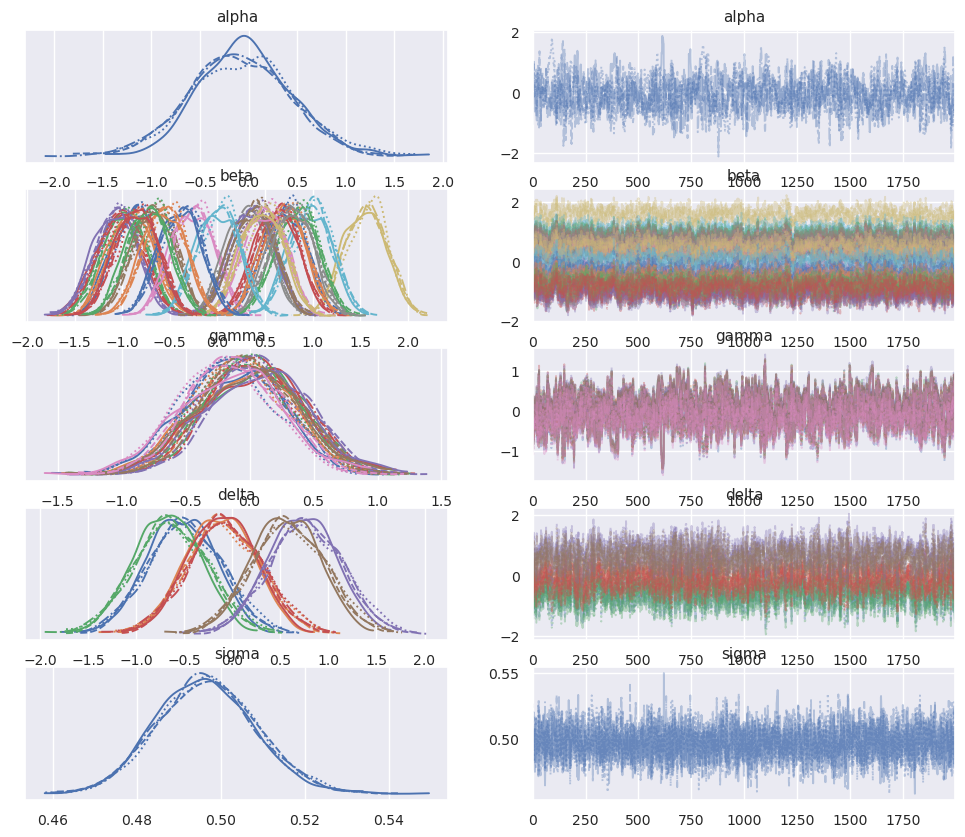

In [16]:
az.plot_trace(idata)

In [17]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    pm.compute_log_likelihood(idata, extend_inferencedata=True)

Sampling: [Y_obs]


In [18]:
az.waic(idata)

/home/cjirmas/miniforge3/envs/ev-analysis/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 920 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -680.19    42.05
p_waic       37.62        -

There has been a warning during the calculation. Please check the results.

In [19]:
az.loo(idata)

Computed from 8000 posterior samples and 920 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -680.26    42.05
p_loo       37.69        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      919   99.9%
 (0.5, 0.7]   (ok)          1    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [20]:
Y_obs = idata.posterior_predictive.mean(("chain", "draw")).Y_obs.values
rmse = np.sqrt(np.mean((Y_obs - X.kWh_std)**2))*X.kWh.std()

print(f"RMSE: {rmse} kWh")

RMSE: 306.5696329665954 kWh


In [21]:
r2 = az.r2_score(X.kWh_std, Y_obs)

r2

r2        0.761241
r2_std    0.000000
dtype: float64

## Model: Hierarchical (pooled hourly/daily)

This model implements partial pooling, grouping on hourly and daily effects.

Given:
- $ \alpha $: Intercept
- $ \beta_i $: Effect of the i-th hour of the day (for $ i = 1, 2, ..., 24 $)
- $ \gamma_j $: Effect of the j-th day of the week (for $ j = 1, 2, ..., 7 $)
- $ \delta_k $: Effect of the k-th year (for $ j = 1, 2, ..., 6 $)
- $ \mu $: Expected kWh charged for a given hour, day, year
- $ \sigma $: Standard deviation of the observations
- $ \sigma_{\beta} $: Standard deviation of the hourly effects
- $ \sigma_{\gamma} $: Standard deviation of the daily effects
- $ Y $: Observed kWh charged (standardized)

The model can be represented as:

1. Prior on the intercept:
$$ \alpha \sim \mathcal{N}(0, 1) $$

2. Priors on the hourly effects:
$$ \beta_i \sim \mathcal{N}(0, \sigma_{\beta}) \quad \text{for} \quad i = 1, 2, ..., 24 $$

3. Priors on the daily effects:
$$ \gamma_j \sim \mathcal{N}(0, \sigma_{\gamma}) \quad \text{for} \quad j = 1, 2, ..., 7 $$

4. Priors on the yearly effects:

$$ \delta_k \sim \mathcal{N}(0, 1) \quad \text{for} \quad j = 1, 2, ..., 6 $$

6. Prior on the standard deviation:
$$ \sigma \sim \text{HalfNormal}(1) $$

7. Hyperpriors:

$$ \sigma_{\beta} \sim \text{Exponential}(1) $$
$$ \sigma_{\gamma} \sim \text{Exponential}(1) $$

6. The linear model for the expected kWh charged given hour and day:
$$ \mu = \alpha + \beta_{X_{\text{hour}}} + \gamma_{X_{\text{day}}} + \delta_{X_{\text{year}}} $$

7. The likelihood of the observed data:
$$ Y \sim \mathcal{N}(\mu, \sigma) $$

In [22]:
with pm.Model(coords=coords) as model2:
    # hyperpriors
    sigma_beta = pm.Exponential("sigma_beta", 1)
    sigma_gamma = pm.Exponential("sigma_gamma", 1)
    
    # hour of day
    beta = pm.Normal("beta", 0, sigma_beta, dims="hour")
    # day of week
    gamma = pm.Normal("gamma", 0, sigma_gamma, dims="day")
    # year
    delta = pm.Normal("delta", 0, 1, dims="year")
    
    mu = beta[X.hour] + gamma[X.day] + delta[X.year_idx]
    sigma = pm.HalfNormal("sigma", 1)

    obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=X.kWh_std)

In [23]:
with model2:
    idata2 = pm.sample(tune=2000, draws=2000, target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_beta, sigma_gamma, beta, gamma, delta, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'sigma_beta'}>,
        <Axes: title={'center': 'sigma_beta'}>],
       [<Axes: title={'center': 'sigma_gamma'}>,
        <Axes: title={'center': 'sigma_gamma'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

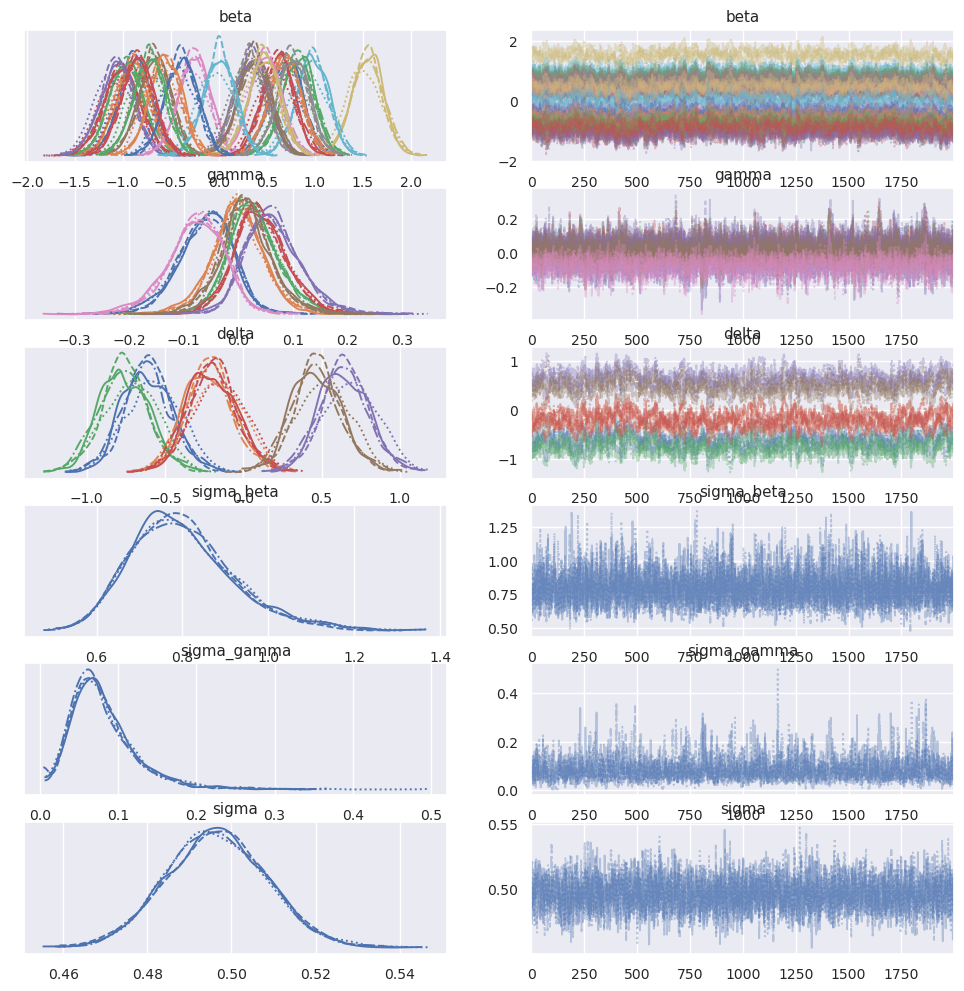

In [24]:
az.plot_trace(idata2)

In [25]:
az.summary(idata2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.881,0.177,-1.223,-0.547,0.010,0.007,337.0,588.0,1.01
beta[1],-0.908,0.182,-1.245,-0.555,0.010,0.007,345.0,538.0,1.01
beta[2],-0.979,0.183,-1.326,-0.638,0.010,0.007,346.0,568.0,1.01
beta[3],-1.020,0.196,-1.401,-0.659,0.010,0.007,388.0,844.0,1.01
beta[4],-1.071,0.184,-1.415,-0.723,0.010,0.007,370.0,759.0,1.01
beta[5],-0.676,0.173,-0.992,-0.346,0.010,0.007,317.0,613.0,1.01
beta[6],-0.266,0.173,-0.594,0.057,0.010,0.007,317.0,544.0,1.01
beta[7],0.311,0.173,-0.020,0.628,0.010,0.007,315.0,544.0,1.01
beta[8],1.538,0.173,1.201,1.858,0.010,0.007,323.0,591.0,1.01
beta[9],0.966,0.173,0.641,1.291,0.010,0.007,315.0,583.0,1.01


In [26]:
with model2:
    pm.compute_log_likelihood(idata2, extend_inferencedata=True)

In [27]:
az.waic(idata2)

/home/cjirmas/miniforge3/envs/ev-analysis/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 920 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -679.65    42.06
p_waic       36.07        -

There has been a warning during the calculation. Please check the results.

In [28]:
az.loo(idata2)

Computed from 8000 posterior samples and 920 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -679.86    42.11
p_loo       36.29        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      918   99.8%
 (0.5, 0.7]   (ok)          2    0.2%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [29]:
with model2:
    pm.sample_posterior_predictive(idata2, extend_inferencedata=True)

Sampling: [Y_obs]


In [30]:
Y_obs = idata2.posterior_predictive.mean(("chain", "draw")).Y_obs.values
rmse2 = np.mean(np.abs(Y_obs - X.kWh_std))*X.kWh.std()

print(f"RMSE: {rmse2} kWh")

RMSE: 220.57552076954497 kWh


In [31]:
r2 = az.r2_score(X.kWh_std, Y_obs)

r2

r2        0.758953
r2_std    0.000000
dtype: float64

Text(0, 0.5, 'Hour')

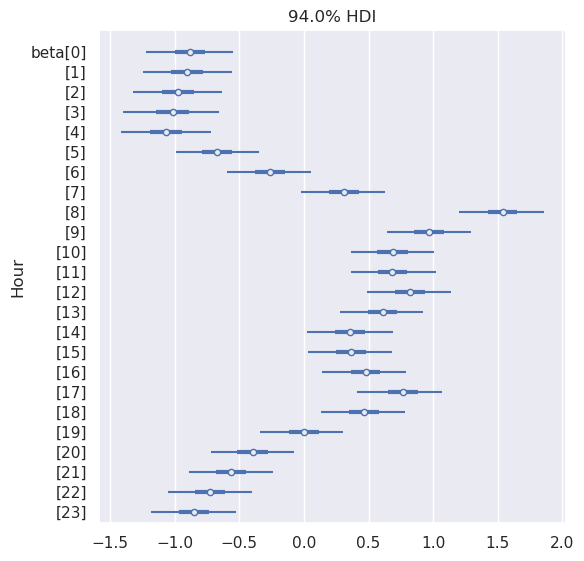

In [32]:
axes = az.plot_forest(idata2, var_names=["beta"], combined=True)
axes[0].set_ylabel("Hour")

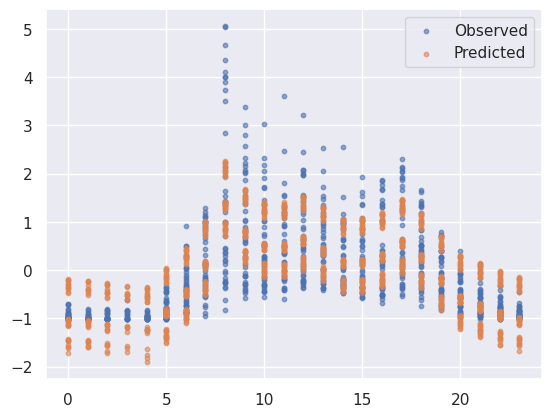

In [33]:
fig, ax = plt.subplots()

ax.scatter(X.hour, X.kWh_std, s=10, alpha=.6, label="Observed")
ax.scatter(X.hour, Y_obs, s=10, alpha=.6, label="Predicted")
# az.plot_hdi(X.hour, idata2.posterior_predictive.Y_obs)

ax.legend()

## Model: Hierarchical (pooled hourly/daily/yearly)

This model implements partial pooling on year as well. It also changes the hyperpriors to allow for more control over variation on different effects.

Given:
- $ \alpha $: Intercept
- $ \beta_i $: Effect of the i-th hour of the day (for $ i = 1, 2, ..., 24 $)
- $ \gamma_j $: Effect of the j-th day of the week (for $ j = 1, 2, ..., 7 $)
- $ \delta_k $: Effect of the k-th year (for $ j = 1, 2, ..., 6 $)
- $ \mu $: Expected kWh charged for a given hour, day, year
- $ \sigma $: Standard deviation of the observations
- $ \sigma_{\beta} $: Standard deviation of the hourly effects (hyperprior)
- $ \sigma_{\gamma} $: Standard deviation of the daily effects (hyperprior)
- $ \sigma_{\delta} $: Standard deviation of the yearly effects (hyperprior)
- $ Y $: Observed kWh charged (standardized)

The model can be represented as:

1. Prior on the intercept:
$$ \alpha \sim \mathcal{N}(0, 1) $$

2. Priors on the hourly effects:
$$ \beta_i \sim \mathcal{N}(0, \sigma_{\beta}) \quad \text{for} \quad i = 1, 2, ..., 24 $$

3. Priors on the daily effects:
$$ \gamma_j \sim \mathcal{N}(0, \sigma_{\gamma}) \quad \text{for} \quad j = 1, 2, ..., 7 $$

4. Priors on the yearly effects:

$$ \delta_k \sim \mathcal{N}(0, \sigma_{\delta}) \quad \text{for} \quad j = 1, 2, ..., 6 $$

6. Prior on the standard deviation:
$$ \sigma \sim \text{HalfNormal}(1) $$

7. Hyperpriors:

$$ \sigma_{\beta} \sim \text{HalfCauchy}(.5) $$
$$ \sigma_{\gamma} \sim \text{Exponential}(1) $$
$$ \sigma_{\delta} \sim \text{Gamma}(1, 2) $$

6. The linear model for the expected kWh charged given hour and day:
$$ \mu = \alpha + \beta_{X_{\text{hour}}} + \gamma_{X_{\text{day}}} + \delta_{X_{\text{year}}} $$

7. The likelihood of the observed data:
$$ Y \sim \mathcal{N}(\mu, \sigma) $$

In [34]:
with pm.Model(coords=coords) as model3:
    # hyperpriors
    sigma_beta = pm.HalfCauchy("sigma_beta", .5)
    sigma_gamma = pm.Exponential("sigma_gamma", 1)
    sigma_delta = pm.Gamma("sigma_delta", 1, 2)
    
    # hour of day
    beta = pm.Normal("beta", 0, sigma_beta, dims="hour")
    # day of week
    gamma = pm.Normal("gamma", 0, sigma_gamma, dims="day")
    # year
    delta = pm.Normal("delta", 0, sigma_delta, dims="year")
    
    mu = beta[X.hour] + gamma[X.day] + delta[X.year_idx]
    sigma = pm.HalfNormal("sigma", 1)

    obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=X.kWh_std)

In [35]:
with model3:
    idata3 = pm.sample(tune=2000, draws=2000, target_accept=.95)
    pm.compute_log_likelihood(idata3, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_beta, sigma_gamma, sigma_delta, beta, gamma, delta, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 30 seconds.


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'sigma_beta'}>,
        <Axes: title={'center': 'sigma_beta'}>],
       [<Axes: title={'center': 'sigma_gamma'}>,
        <Axes: title={'center': 'sigma_gamma'}>],
       [<Axes: title={'center': 'sigma_delta'}>,
        <Axes: title={'center': 'sigma_delta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

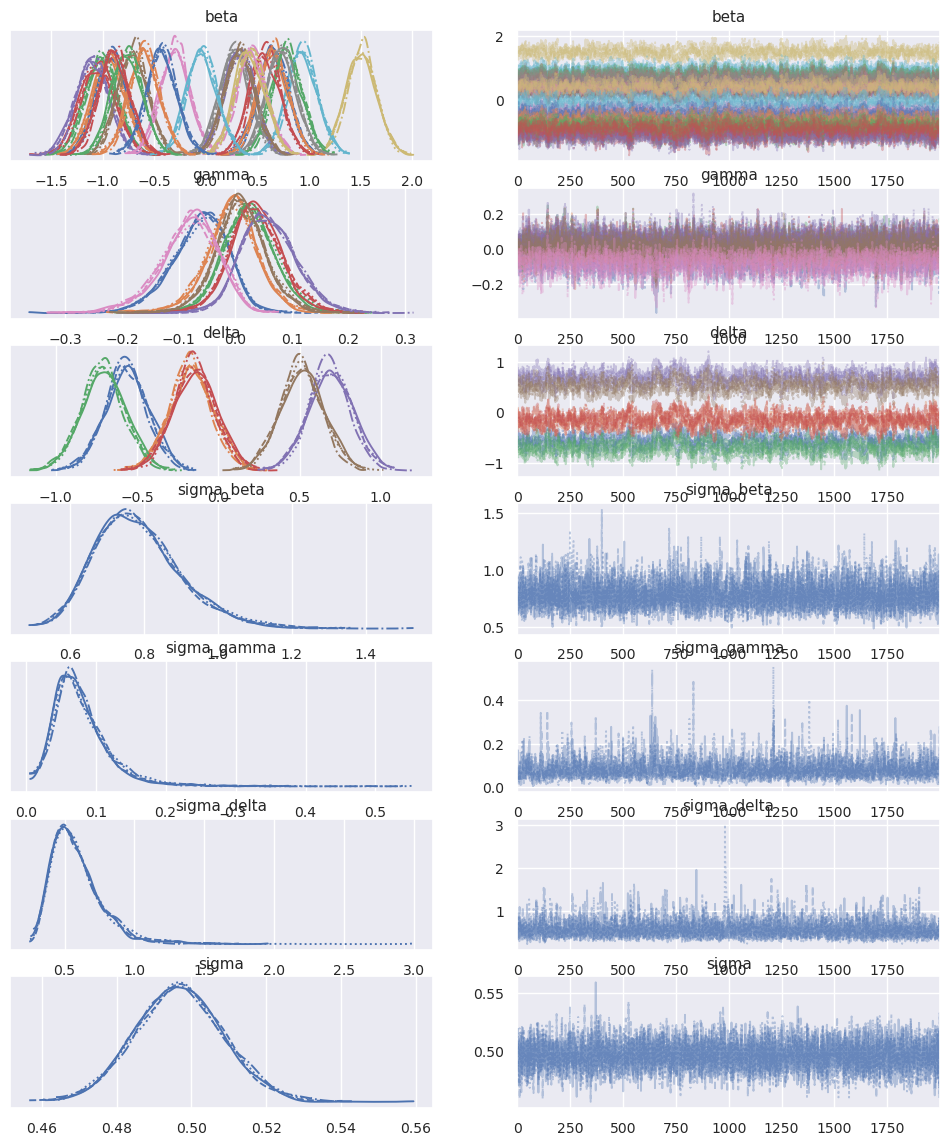

In [36]:
az.plot_trace(idata3)

In [37]:
az.summary(idata3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.912,0.152,-1.197,-0.628,0.006,0.004,570.0,1312.0,1.01
beta[1],-0.940,0.158,-1.230,-0.632,0.006,0.005,607.0,1324.0,1.01
beta[2],-1.011,0.159,-1.301,-0.705,0.006,0.005,610.0,1312.0,1.01
beta[3],-1.048,0.172,-1.356,-0.714,0.006,0.004,740.0,1846.0,1.00
beta[4],-1.099,0.161,-1.396,-0.792,0.006,0.004,644.0,1199.0,1.01
beta[5],-0.707,0.148,-0.985,-0.431,0.006,0.004,546.0,1136.0,1.01
beta[6],-0.299,0.147,-0.593,-0.033,0.006,0.004,549.0,1099.0,1.01
beta[7],0.279,0.147,0.005,0.559,0.006,0.004,544.0,1101.0,1.01
beta[8],1.505,0.148,1.238,1.793,0.006,0.004,558.0,1144.0,1.01
beta[9],0.933,0.147,0.645,1.209,0.006,0.004,551.0,1188.0,1.01


Text(0, 0.5, 'Hour')

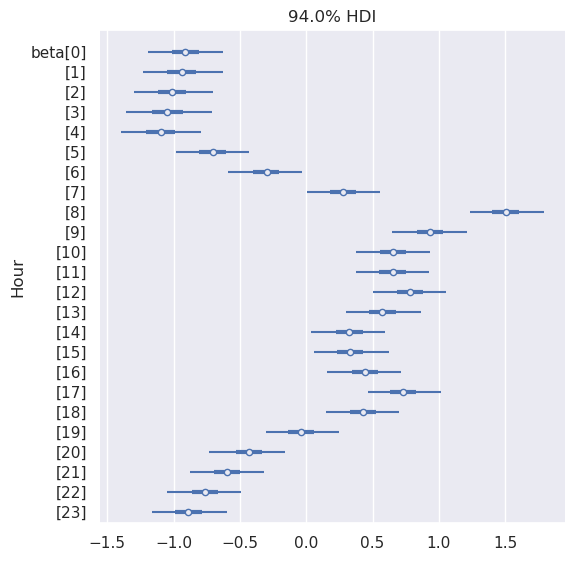

In [38]:
axes = az.plot_forest(idata3, var_names=["beta"], combined=True)
axes[0].set_ylabel("Hour")

Text(0, 0.5, 'Day')

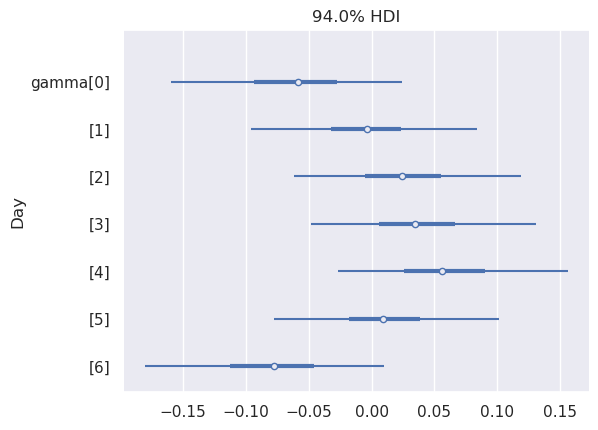

In [39]:
axes = az.plot_forest(idata3, var_names=["gamma"], combined=True)
axes[0].set_ylabel("Day")

Text(0, 0.5, 'Year')

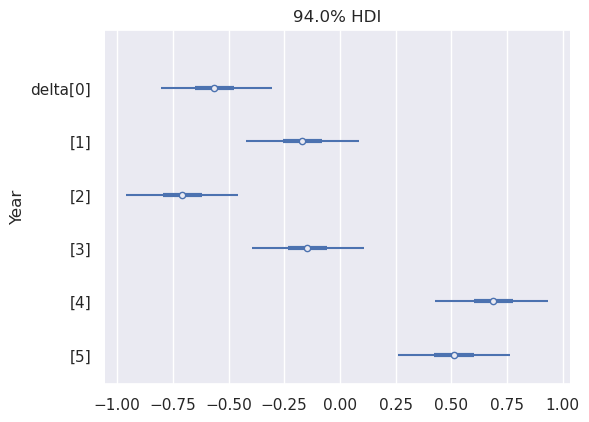

In [40]:
axes = az.plot_forest(idata3, var_names=["delta"], combined=True)
axes[0].set_ylabel("Year")

In [41]:
with model3:
    pm.sample_posterior_predictive(idata3, extend_inferencedata=True)

Sampling: [Y_obs]


In [42]:
az.loo(idata3)

Computed from 8000 posterior samples and 920 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -679.80    42.12
p_loo       36.07        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      920  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [43]:
Y_obs = idata3.posterior_predictive.mean(("chain", "draw")).Y_obs.values
rmse3 = np.mean(np.abs(Y_obs - X.kWh_std))*X.kWh.std()

print(f"RMSE: {rmse3} kWh")

RMSE: 220.48604818096874 kWh


In [44]:
r2 = az.r2_score(X.kWh_std, Y_obs)

r2

r2        0.758435
r2_std    0.000000
dtype: float64

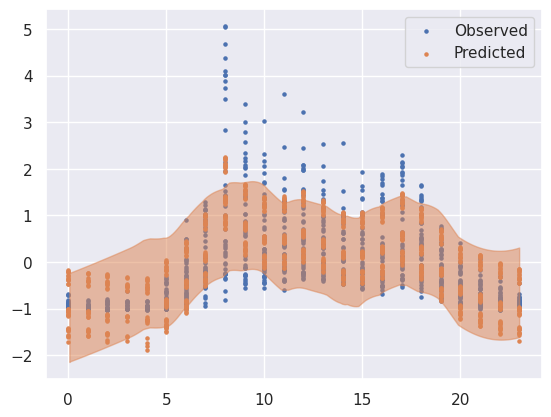

In [45]:
fig, ax = plt.subplots()

ax.scatter(X.hour, X.kWh_std, s=5, label="Observed")
ax.scatter(X.hour, Y_obs, s=5, label="Predicted")
az.plot_hdi(X.hour, idata3.posterior_predictive.Y_obs)

ax.legend()

## Non-parametric

### Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [47]:
rf = RandomForestRegressor()

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X[["year_idx", "hour", "day"]], X.kWh)

In [49]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [50]:
rf.score(X_train, y_train)

0.9888907036980078

In [51]:
rf.score(X_test, y_test)

0.9264221453205624

In [52]:
y_pred = rf.predict(X_train)

rmse = mean_squared_error(y_pred, y_train, squared=False)
print(f"RMSE (train):{rmse} kWh")

RMSE (train):66.68273058129722 kWh


In [53]:
y_pred = rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE (test):{rmse} kWh")

RMSE (test):168.5737029038538 kWh
